In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib import sig_gen
import tensorflow as tf
from tensorflow.keras import layers
from numba import jit, njit, prange

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [3]:
@njit(parallel=True)
def sig_batch_gen(batch, symb, sps):
    """
    generate a signal batch
    no distortion yet
    """
    mibt = np.random.random((batch, 2))*0.8+0.3
    sig = np.empty((batch, symb*sps, 2))
    for idx in prange(batch):
        msg = np.random.randint(0, 2, symb)
        # generate oversampled signal
        sig_cpx = sig_gen.gfsk_mod(msg, sps*10, mibt[idx, 0], mibt[idx, 1])
        # apply timing offset
        sig_cpx = sig_cpx[np.random.randint(0, 10)::10]
        # parallel stuck if apply phase offset, move it to sig_gen
        # sig_cpx = sig_cpx*np.exp(1j*2*np.pi*np.random.random())
        sig[idx, :, 0] = sig_cpx.real
        sig[idx, :, 1] = sig_cpx.imag
    return sig, mibt

# sig, mibt = sig_batch_gen(batch, symb, sps)
# print(sig.shape, mibt.shape)
def train_generator(batch, symb, sps):
    while True:
        yield sig_batch_gen(batch, symb, sps)

        
batch = 1024
symb, sps = 64, 4
gen = train_generator(batch, symb, sps)
next(gen)[0].shape
# sig_batch_gen(batch, symb, sps)

(1024, 256, 2)

In [6]:

%timeit sig_batch_gen(batch, symb, sps)

6.44 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
def build_model(input_shape):
    # build model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(16, 7, activation='relu',
                            input_shape=input_shape))
    model.add(layers.Conv1D(32, 7, activation='relu', strides=2))
    model.add(layers.Conv1D(32, 7, activation='relu', strides=2))
    model.add(layers.Conv1D(32, 7, activation='relu'))
#     model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))

    model.compile(optimizer='Adam',loss='mae')
    model.summary()

    return model

model = build_model((symb*sps, 2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 250, 16)           240       
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 122, 32)           3616      
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 58, 32)            7200      
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 52, 32)            7200      
_________________________________________________________________
flatten_21 (Flatten)         (None, 1664)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 3330      
Total params: 21,586
Trainable params: 21,586
Non-trainable params: 0
_________________________________________________________________


In [94]:
# sanity check
# x_test = np.random.rand(5, 256, 2)
# model.predict(x_test).shape

In [95]:
history = model.fit_generator(
    gen,
    steps_per_epoch=200,
    epochs=10
    )
model.save('mibt_est.h5')

Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1267
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0921
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0829
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0669
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0587
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0555
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0531
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0545
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0500
Epoch 10/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0480


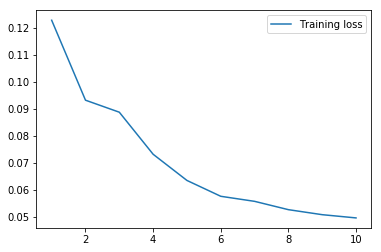

In [91]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.legend()
plt.show()

In [87]:
batch = 1
symb, sps = 64, 4
x_test, target = sig_batch_gen(batch, symb, sps)
print(model.predict(x_test), target)


[[0.34392264 0.30266353]] [[0.31905945 0.32253489]]
